This notebook will try and predict one NM from another one using the low dimensional embeddings from CEBRA.

In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import cebra_pack.utils as cp
import sklearn.linear_model
import logging


from matplotlib.collections import LineCollection
import pandas as pd

/opt/conda/lib/python3.10/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


## A. Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [2]:
pd.__version__

'2.0.3'

In [3]:
#pip install pandas==2.0.0

In [2]:
# load the dataframe that contains data from 1 session
try:
    df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))
    print("Loaded df.pkl from the local path.")
except FileNotFoundError:
    df_trials_ses = pickle.load(open('/data/df.pkl', "rb"))
    print("Loaded df.pkl from the CO path.")


Loaded df.pkl from the CO path.


In [3]:
n_trials = 1765

In [4]:
# download the dictionary containing the traces
try:
    traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))
    print("Loaded traces.pkl from the local path.")
except FileNotFoundError:
    traces = pickle.load(open('/data/traces.pkl', "rb"))
    print("Loaded traces.pkl from the alternate path.")


Loaded traces.pkl from the alternate path.


In [5]:
# load the trace times
try:
    trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)
    print("Loaded Trace times.npy from the local path.")
except FileNotFoundError:
    trace_times = np.load('/data/Trace times.npy', allow_pickle=True)
    print("Loaded Trace times.npy from the alternate path.")

Loaded Trace times.npy from the alternate path.


In [6]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [7]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)
all_nms.shape

(218572, 4)

## B. Format the Data

In [8]:
# get all NMs
formatted_nms, reward_labels, choice_labels, rpe_labels_ = cp.format_data(all_nms,df=df_trials_ses,trace_times_=trace_times, choice_times_=choice_times)

neural tensor shape:  torch.Size([1717, 80])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [9]:
# get individual NMs
ind_nms = cp.individual_datasets(traces_=traces)

shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)


In [11]:
torch.cuda.is_available()

True

In [29]:
formatted_ind_nms = [cp.format_data(ind_nm, df_trials_ses, trace_times, choice_times)[0] for ind_nm in ind_nms]

neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [30]:
rewarded, unrewarded = cp.define_label_classes(reward_labels)

In [31]:
formatted_nms.shape[0]

1717

In [32]:
# add zeros to the individual nms data so the input dimensionality is the same as all_nms
zeros = np.zeros((formatted_nms.shape[0],60))

In [33]:
expanded_ind_nms = [torch.from_numpy(np.hstack((ind_nm, zeros))) for ind_nm in formatted_ind_nms]

In [42]:
expanded_ind_nms[3][:,18]

tensor([-0.0080,  0.0014, -0.0008,  ...,  0.0019,  0.0020,  0.0025],
       dtype=torch.float64)

## C. Build and train the CEBRA model then compute embeddings

In [48]:
# train CEBRA on all nms then produce embeddings for individual nms
def multi_embed_NMs(all_nms, ind_nms, b_label, max_iterations=2000, d=3, metric='euclidean', arch = 'offset10-model-mse'):


    # build time and behaviour models
    cebra_time_model = CEBRA(model_architecture=arch,
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=d,
                        max_iterations=max_iterations,
                        distance=metric,
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10) 

    cebra_behaviour_model = CEBRA(model_architecture=arch,
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=d,
                        max_iterations=max_iterations,
                        distance=metric,
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

    # train them both
    cebra_time_model.fit(all_nms)
    cebra_behaviour_model.fit(all_nms, b_label)

    # compute the embeddings for the individual nms
    time_embeddings = [cebra_time_model.transform(ind_nm) for ind_nm in ind_nms]
    behaviour_embeddings = [cebra_behaviour_model.transform(ind_nm) for ind_nm in ind_nms]

    # comput embeddings for all nms
    time_embeddings.append(cebra_time_model.transform(all_nms))
    behaviour_embeddings.append(cebra_behaviour_model.transform(all_nms))


    return time_embeddings, behaviour_embeddings

In [49]:
time_embeddings, behaviour_embeddings = multi_embed_NMs(all_nms=formatted_nms, ind_nms=expanded_ind_nms,b_label=reward_labels)

pos:  0.9598 neg:  2.7480 total:  3.7078 temperature:  1.0000: 100%|██████████| 2000/2000 [00:16<00:00, 122.60it/s]
pos:  0.3180 neg:  5.4538 total:  5.7718 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 149.17it/s]


# D. View Embeddings

Now let's view the embeddings and compare them with those generated from independent CEBRA models.

In [18]:
# define a function to view the embeddings
def view(time_embedding, behaviour_embedding, labels, label_classes, size=5):
 
    # create a figure and make the plots
    fig = plt.figure(figsize=(17,8))
    gs = gridspec.GridSpec(1, 2, figure=fig)


    ax81 = fig.add_subplot(gs[0,0], projection='3d')
    ax82 = fig.add_subplot(gs[0,1], projection='3d')
    
    for ax in [ax81,ax82]:
        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


    # colour maps
    colours = ['cool', 'plasma', 'spring']

    # plot the time embedding 
    cebra.plot_embedding(embedding=time_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax81, markersize=size, title='Time embedding', cmap=colours[0])
    cebra.plot_embedding(embedding=time_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax81, markersize=size, title='Time embedding, AUC: {}'.format(np.round(mean_scores[0],2)), cmap=colours[1])


    # plot the behaviour embedding 
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax82, markersize=size, title='Behaviour embedding', cmap=colours[0],)
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax82,markersize=size, title='Behaviour embedding, AUC: {}'.format(np.round(mean_scores[1],2)),  cmap=colours[1])

    gs.tight_layout(figure=fig)

In [100]:
# first make function to make the plots given a list of embeddings
def plot4_embeddings(embeddings, labels , l_class, t=""):

    # number of plots
    n_plots = len(embeddings)

    n_columns = 2
    n_rows = (n_plots + 1) // n_columns

    # create axis
    fig = plt.figure(figsize=(16, 4*n_rows))
    gs = gridspec.GridSpec(n_rows, n_columns, figure=fig)

    # colour 
    c = ['cool','plasma','pink','winter']

    for i, embed in enumerate(embeddings):

        # create the axes
        ax = fig.add_subplot(gs[i // n_columns, i%n_columns], projection='3d')

        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


        aucs, errors = np.round(cp.get_auc(embeddings, labels),3)
        titles=['DA only, AUC:{}'.format(aucs[0]),'NE only, AUC:{}'.format(aucs[1]), '5HT only, AUC:{}'.format(aucs[2]), 'ACh only, AUC:{}'.format(aucs[3]), f'All nms, AUC:{aucs[4]}']


        # plot the embedding
        cebra.plot_embedding(embedding=embed[l_class[0],:], embedding_labels=labels[l_class[0]], ax=ax, markersize=2,title=titles[i], cmap=c[0])
        cebra.plot_embedding(embedding=embed[l_class[1],:], embedding_labels=labels[l_class[1]], ax=ax, markersize=2,title=titles[i], cmap=c[1])

    plt.suptitle(t, fontsize=15)
    plt.tight_layout()
    plt.show()

In [99]:
len(behaviour_embeddings)

5

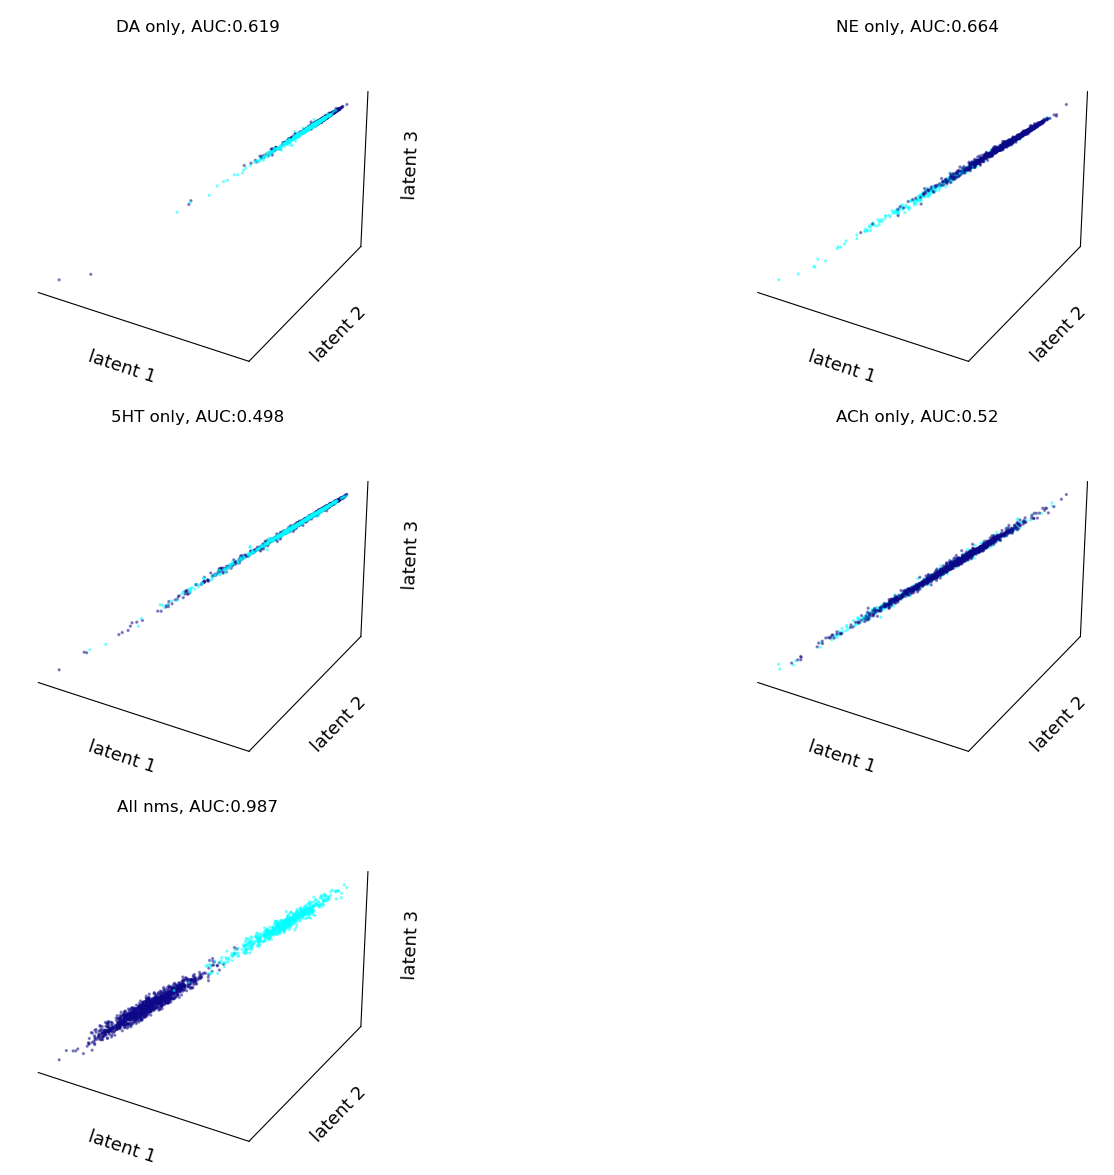

In [101]:
# %matplotlib inline
plot4_embeddings(behaviour_embeddings,reward_labels, [rewarded, unrewarded])

## E. Predict one NM from an embedding of another NM

In [102]:
target_nm = behaviour_embeddings[0]
input_nm = behaviour_embeddings[1]

In [103]:
score, prediction = cp.reconstruction_score(input_nm, target_nm)

In [104]:
score

0.48017558455467224

In [107]:
view_embedding(input_nm, target_nm)

NameError: name 'view_embedding' is not defined